#### ClinVar Missense Pathogenicity Analysis

In [34]:
import pandas as pd
import numpy as np
import requests
import gzip
import shutil
from pathlib import Path
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Fetch and Filter Data

In [15]:
# Data source configuration
CLINVAR_URL = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz"
CLINVAR_GZ = "variant_summary.txt.gz"
CLINVAR_TXT = "variant_summary.txt"
OUTPUT_CSV = "clinvar_missense_variants.csv"

# Filtering criteria
VALID_SIGNIFICANCE = {"Pathogenic", "Likely pathogenic", "Benign", "Likely benign"}
GENOME_BUILD = "GRCh38"  # Compatible with AlphaFold, Ensembl, UniProt
CHUNK_SIZE = 100_000

# Precompiled regex patterns for efficiency
HAS_P_PROTEIN_CHANGE = re.compile(r"\(p\.", re.ASCII)
EXTRACT_PROTEIN_CHANGE = re.compile(r"\(p\.(.*?)\)", re.ASCII)
IS_MISSENSE = re.compile(r"^[A-Z][a-z]{2}\d+[A-Z][a-z]{2}$", re.ASCII)

# Columns to read (memory optimization)
READ_COLS = ["Assembly", "Type", "ClinicalSignificance", "Name", "GeneSymbol", "HGNC_ID"]

In [16]:
def download_and_extract_clinvar() -> None:
    if not Path(CLINVAR_GZ).exists():
        with requests.get(CLINVAR_URL, stream=True) as r:
            r.raise_for_status()
            with open(CLINVAR_GZ, "wb") as f_out:
                shutil.copyfileobj(r.raw, f_out)

    if not Path(CLINVAR_TXT).exists():
        with gzip.open(CLINVAR_GZ, "rb") as f_in, open(CLINVAR_TXT, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

In [17]:
def filter_chunk(chunk: pd.DataFrame) -> pd.DataFrame:
    """
    Filter ClinVar chunk for protein-coding missense SNVs with clear clinical significance, using GRCh38 coordinates.
    """
    # Initial filters for relevant vatiant type

    chunk = chunk[
        (chunk["Assembly"] == GENOME_BUILD)
        & (chunk["Type"] == "single nucleotide variant")
        & (chunk["ClinicalSignificance"].isin(VALID_SIGNIFICANCE))
        & (chunk["Name"].str.contains(HAS_P_PROTEIN_CHANGE, na=False))
    ].copy()

    # Extract protein change string
    
    chunk["protein_change"] = chunk["Name"].str.extract(EXTRACT_PROTEIN_CHANGE)

    # Keep only missense variants
    # Match: 3-letter AA, position, and new AA

    missense_mask = chunk["protein_change"].str.match(IS_MISSENSE, na=False)
    chunk = chunk[missense_mask].copy()

    return chunk[
        ["GeneSymbol", "HGNC_ID", "ClinicalSignificance", "Name", "protein_change"]
    ].rename(
        columns={"GeneSymbol": "gene"}
    )


In [18]:
def filter_missense_variants_streaming() -> None:
    reader = pd.read_csv(
        CLINVAR_TXT,
        sep="\t",
        chunksize=CHUNK_SIZE,
        low_memory=False,
        usecols=READ_COLS,
        dtype={"Assembly": "category", "Type": "category", "ClinicalSignificance": "category"},
    )

    is_first = True
    total = 0

    for chunk in reader:
        filtered = filter_chunk(chunk)
        if not filtered.empty:
            filtered.to_csv(OUTPUT_CSV, mode="w" if is_first else "a", header=is_first, index=False)
            is_first = False
            total += len(filtered)
    
    print(f"Saved {total} missense variants to {OUTPUT_CSV}.")

In [19]:
# Main execution

if __name__ == "__main__":
    download_and_extract_clinvar()
    filter_missense_variants_streaming()

Saved 239112 missense variants to clinvar_missense_variants.csv.


##### Feature Extraction

In [21]:
# Load pre-parsed ClinVar VCF
clinvar_df = pd.read_csv("clinvar_missense_variants.csv")

# Inspect
clinvar_df.head()
clinvar_df[clinvar_df['protein_change'].notna()]

,gene,HGNC_ID,ClinicalSignificance,Name,protein_change
0,FOXRED1,HGNC:26927,Pathogenic,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),Gln232Ter
1,FOXRED1,HGNC:26927,Likely pathogenic,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),Asn430Ser
2,HFE,HGNC:4886,Pathogenic,NM_000410.4(HFE):c.989G>T (p.Arg330Met),Arg330Met
3,WDR35,HGNC:29250,Pathogenic,NM_020779.4(WDR35):c.1844A>G (p.Glu615Gly),Glu615Gly
4,WDR35,HGNC:29250,Likely pathogenic,NM_020779.4(WDR35):c.2590G>A (p.Ala864Thr),Ala864Thr
...,...,...,...,...,...
239107,CUL4B,HGNC:2555,Likely pathogenic,NM_001079872.2(CUL4B):c.1051C>T (p.Arg351Ter),Arg351Ter
239108,COL4A1,HGNC:2202,Likely pathogenic,NM_001845.6(COL4A1):c.3877G>A (p.Gly1293Ser),Gly1293Ser
239109,ATRX,HGNC:886,Likely pathogenic,NM_000489.6(ATRX):c.5651C>T (p.Thr1884Ile),Thr1884Ile
239110,IRF6,HGNC:6121,Pathogenic,NM_006147.4(IRF6):c.947T>C (p.Leu316Pro),Leu316Pro


In [22]:
## Parse protein_change into components

def parse_protein_change(change):
    match = re.match(r'^([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})$', change)
    if match:
        ref, pos, alt = match.groups()
        return pd.Series([ref, int(pos), alt])
    return pd.Series([None, None, None])

clinvar_df[['aa_ref_3', 'aa_pos', 'aa_alt_3']] = clinvar_df['protein_change'].apply(parse_protein_change)

In [24]:
# Load amino acid properties from CSV files and create dictionaries
aa_3to1_df = pd.read_csv('aa_features/aa_3to1_mapping.csv')
aa_polarity_df = pd.read_csv('aa_features/aa_polarity.csv')
aa_charge_df = pd.read_csv('aa_features/aa_charge.csv')
aa_volume_df = pd.read_csv('aa_features/aa_volume.csv')

# Create lookup dictionaries from CSV data
AA3_to_1 = dict(zip(aa_3to1_df['aa_3letter'], aa_3to1_df['aa_1letter']))
aa_polarity = dict(zip(aa_polarity_df['aa_1letter'], aa_polarity_df['polarity']))
aa_charge = dict(zip(aa_charge_df['aa_1letter'], aa_charge_df['charge']))
aa_volume = dict(zip(aa_volume_df['aa_1letter'], aa_volume_df['volume']))

# Load Grantham matrix and create symmetric lookup
grantham_df = pd.read_csv('aa_features/grantham_matrix.csv')
symmetric_grantham = {}
for _, row in grantham_df.iterrows():
    symmetric_grantham[(row['aa_ref'], row['aa_alt'])] = row['grantham_score']
    symmetric_grantham[(row['aa_alt'], row['aa_ref'])] = row['grantham_score']

In [25]:
# Convert to 1-letter codes
clinvar_df['aa_ref'] = clinvar_df['aa_ref_3'].map(AA3_to_1)
clinvar_df['aa_alt'] = clinvar_df['aa_alt_3'].map(AA3_to_1)

# Drop rows with missing or invalid amino acid codes
valid_aas = set("ARNDCQEGHILKMFPSTWYV")
clinvar_df = clinvar_df[
    clinvar_df['aa_ref'].isin(valid_aas) &
    clinvar_df['aa_alt'].isin(valid_aas)
]

# Drop rows with missing position
clinvar_df = clinvar_df[clinvar_df['aa_pos'].notna()]

In [26]:
# Complete feature columns

# Grantham distance
def get_grantham(row):
    return symmetric_grantham.get((row['aa_ref'], row['aa_alt']), None)

clinvar_df['grantham'] = clinvar_df.apply(get_grantham, axis=1)

# Polarity shift
def get_polarity_change(row):
    ref = aa_polarity.get(row['aa_ref'])
    alt = aa_polarity.get(row['aa_alt'])
    return f"{ref}_to_{alt}" if ref and alt else None

clinvar_df['polarity_change'] = clinvar_df.apply(get_polarity_change, axis=1)

# Charge change

def get_charge_change(row):
    ref = aa_charge.get(row['aa_ref'])
    alt = aa_charge.get(row['aa_alt'])
    return f"{ref}_to_{alt}" if ref and alt else None

clinvar_df['charge_change'] = clinvar_df.apply(get_charge_change, axis=1)

# Volume change

def get_volume_diff(row):
    v1 = aa_volume.get(row['aa_ref'])
    v2 = aa_volume.get(row['aa_alt'])
    return abs(v2 - v1) if v1 and v2 else None

clinvar_df['volume_diff'] = clinvar_df.apply(get_volume_diff, axis=1)

In [27]:
# Convert ClinicalSignificance to binary for analysis

clinvar_df['label'] = clinvar_df['ClinicalSignificance'].map({
    'Pathogenic': 1,
    'Likely pathogenic': 1,
    'Benign': 0,
    'Likely benign': 0
})
clinvar_df = clinvar_df[clinvar_df['label'].notna()]

In [28]:
clinvar_df.to_csv("clinvar_missense_with_features.csv", index=False)

##### Visualize Features vs. Pathogenicity

In [30]:
# df = pd.read_csv("clinvar_missense_with_features.csv")
df = clinvar_df.copy()

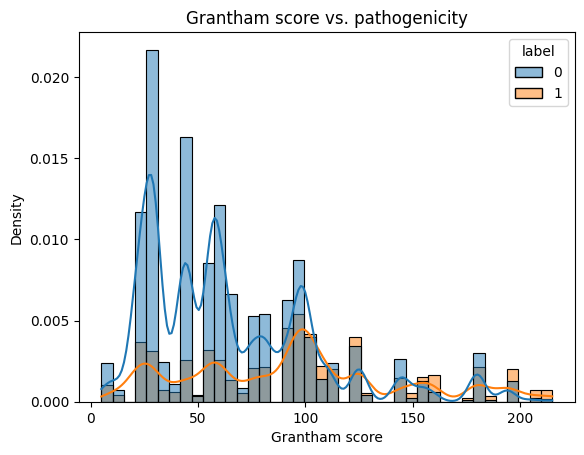

In [35]:
# Plot distribution of Grantham scores

sns.histplot(data=df, x='grantham', hue='label', bins=40, kde=True, stat="density")
plt.title("Grantham score vs. pathogenicity")
plt.xlabel("Grantham score")
plt.ylabel("Density")
plt.show();

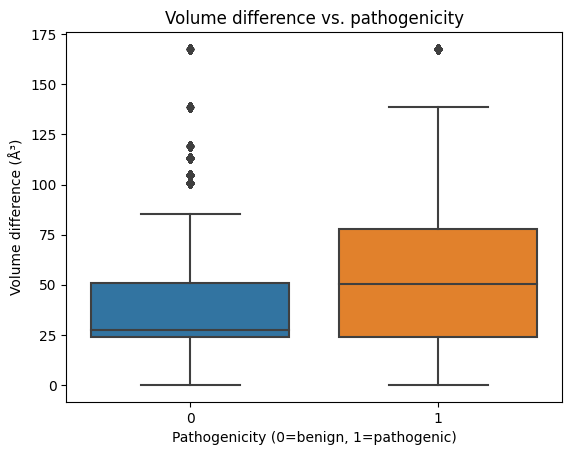

In [37]:
# Box plot of volume difference

sns.boxplot(data=df, x='label', y='volume_diff')
plt.title("Volume difference vs. pathogenicity")
plt.xlabel("Pathogenicity (0=benign, 1=pathogenic)")
plt.ylabel("Volume difference (Å³)")
plt.show()

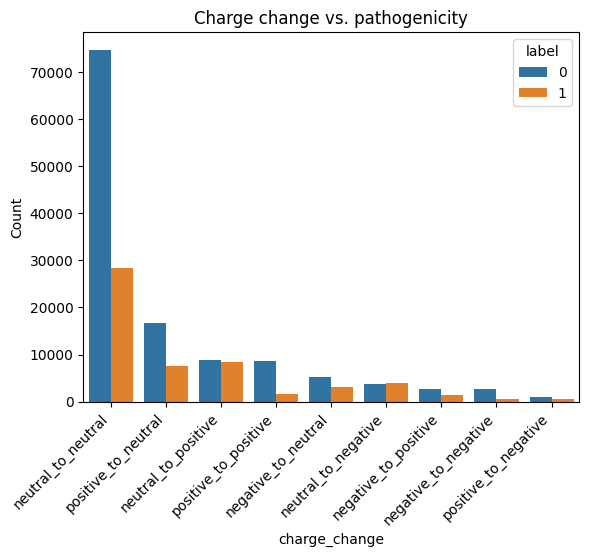

In [38]:
# Bar chart for charge changes

sns.countplot(data=df, x='charge_change', hue='label', order=df['charge_change'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Charge change vs. pathogenicity")
plt.ylabel("Count")
plt.show()

##### Train & evaluate a classifier

In [48]:
# Machine learning imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, classification_report,
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)

In [54]:
# Binary label
df['label'] = df['ClinicalSignificance'].map({
    'Pathogenic': 1,
    'Likely pathogenic': 1,
    'Benign': 0,
    'Likely benign': 0
})
df = df[df['label'].notna()]

In [55]:
# Select features

features = [
    'grantham',
    'volume_diff',
    'charge_change',
    'polarity_change',
]

# Define numeric and categorical features for preprocessing
num_features = ['grantham', 'volume_diff']
cat_features = ['charge_change', 'polarity_change']

X_raw = df[features]
y = df['label']

In [56]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, stratify=y, test_size=0.2, random_state=1
)


In [57]:
# Build and train a classifier

# Define preprocessor, encoding categorical features
preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
])

# Define full pipeline

clf_weighted = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=1,
        class_weight='balanced'
    ))
])

# Fit pipeline directly

clf_weighted.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['grantham', 'volume_diff']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['charge_change',
                                                   'polarity_change'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=1))])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.6900636836397007
ROC AUC: 0.7599463248929512
Confusion Matrix:
 [[17225  7658]
 [ 3487  7589]]
              precision    recall  f1-score   support

           0       0.83      0.69      0.76     24883
           1       0.50      0.69      0.58     11076

    accuracy                           0.69     35959
   macro avg       0.66      0.69      0.67     35959
weighted avg       0.73      0.69      0.70     35959



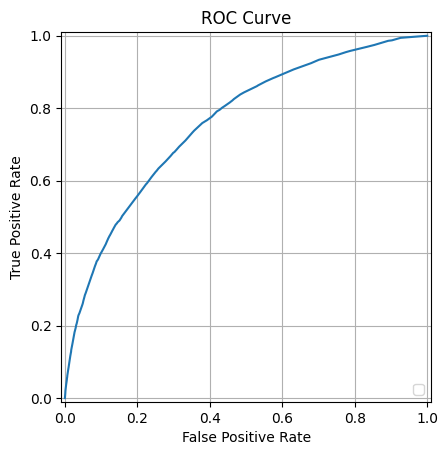

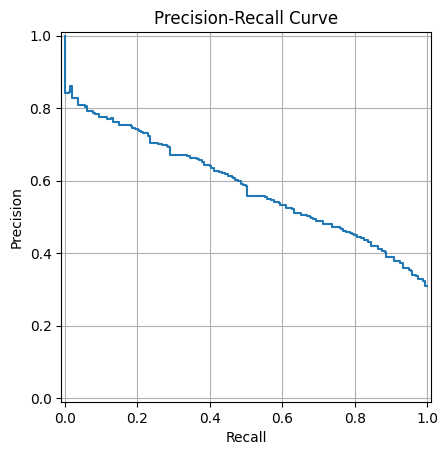

In [58]:
# Evaluate model

y_pred = clf_weighted.predict(X_test)
y_prob = clf_weighted.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve (Receiver Operating Characteristic)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

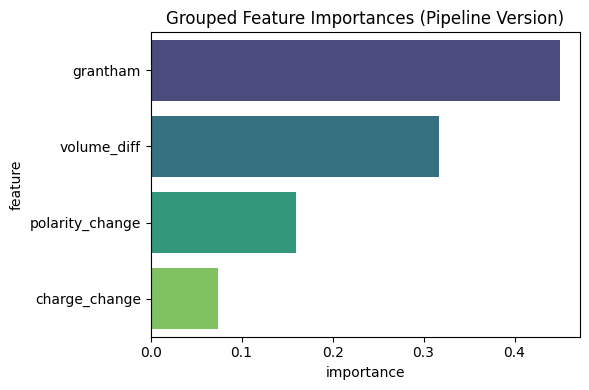

In [59]:
# Feature Importances

# Access inner model and preprocessor
rf_model = clf_weighted.named_steps['rf']
pre = clf_weighted.named_steps['pre']

# Get one-hot encoded categorical feature names
encoded_cat_features = list(
    pre.transformers_[1][1].get_feature_names_out(cat_features)
)

# Combine numeric + encoded categorical feature names
encoded_feature_names = num_features + encoded_cat_features

# Extract importances from the Random Forest inside the pipeline
importances = rf_model.feature_importances_

# Group similar features for interpretability
grouped = {
    'grantham': 0,
    'volume_diff': 0,
    'charge_change': 0,
    'polarity_change': 0,
}

for feature, importance in zip(encoded_feature_names, importances):
    if feature.startswith('charge_change_'):
        grouped['charge_change'] += importance
    elif feature.startswith('polarity_change_'):
        grouped['polarity_change'] += importance
    elif feature in grouped:
        grouped[feature] += importance
    # otherwise ignore minor encodings

# Convert to DataFrame for plotting
grouped_df = (
    pd.DataFrame.from_dict(grouped, orient='index', columns=['importance'])
    .sort_values(by='importance', ascending=False)
    .reset_index()
    .rename(columns={'index': 'feature'})
)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='importance', y='feature', data=grouped_df, palette='viridis')
plt.title("Grouped Feature Importances (Pipeline Version)")
plt.tight_layout()
plt.show()

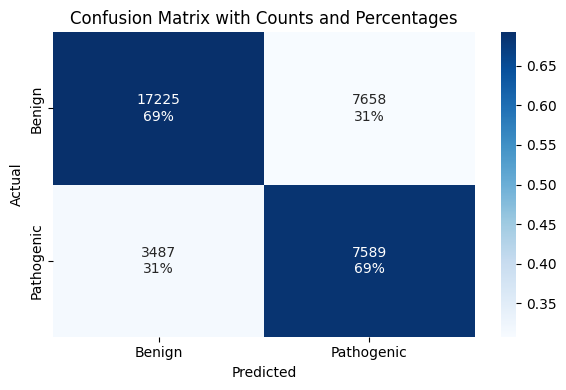

In [60]:
# Generate predictions
y_pred_w = clf_weighted.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_w)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create labels for each cell (e.g. "7378\n68%")
labels = np.array([
    [f"{count}\n{percent:.0%}" for count, percent in zip(row_cm, row_norm)]
    for row_cm, row_norm in zip(cm, cm_normalized)
])

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Benign', 'Pathogenic'],
            yticklabels=['Benign', 'Pathogenic'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts and Percentages')
plt.tight_layout()
plt.show()

##### Additional feature engineering

In [61]:
from Bio.Align import substitution_matrices
from Bio.PDB import PDBParser
from bs4 import BeautifulSoup

In [62]:
# BLOSUM62 substitution matrix based on evolutionary likelihood of AA changes

blosum62 = substitution_matrices.load("BLOSUM62")

In [63]:
def get_blosum_score(aa1, aa2):
    """
    Looks up the BLOSUM62 substitution score for two amino acids.
    Handles symmetric lookup and invalid characters.
    """
    try:
        return blosum62[aa1, aa2]
    except KeyError:
        try:
            return blosum62[aa2, aa1]  # BLOSUM is symmetric
        except KeyError:
            return np.nan

In [64]:
# Apply BLOSUM62 to clinvar_df
clinvar_df['blosum_score'] = clinvar_df.apply(
    lambda row: get_blosum_score(row['aa_ref'], row['aa_alt']) if pd.notna(row['aa_ref']) and pd.notna(row['aa_alt']) else np.nan,
    axis=1
)


In [65]:
# Use AlphaFold to flag whether residue is in a high-confidence strutured region or a disordered region

def get_uniprot_id(gene_symbol):
    """
    Return reviewed UniProt ID for a given human gene symbol (Homo sapiens, taxon ID 9606).
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    query = f"reviewed:true AND gene_exact:{gene_symbol} AND organism_id:9606"
    params = {
        "query": query,
        "format": "json",
        "fields": "accession",
        "size": 1
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if data.get("results"):
            return data["results"][0]["primaryAccession"]
        else:
            print(f"No reviewed UniProt ID found for gene: {gene_symbol}")
            return None
    except Exception as e:
        print(f"Error querying UniProt: {e}")
        return None

In [67]:
pdb_folder = "pdb_files"
os.makedirs(pdb_folder, exist_ok=True)

def download_alphafold_pdb(uniprot_id, save_path=None):
    """
    Downloads the AlphaFold PDB file for a given UniProt ID.
    Saves files in the pdb_files/ subfolder.
    Returns the local path to the saved file.
    """
    base_url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v6.pdb"
    if save_path is None:
        save_path = os.path.join(pdb_folder, f"{uniprot_id}.pdb")

    response = requests.get(base_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded AlphaFold structure for {uniprot_id} to {save_path}")
        return save_path
    else:
        raise ValueError(f"Failed to download AlphaFold model for {uniprot_id} (status {response.status_code})")

In [68]:
def extract_plddt_scores(pdb_path):
    """
    Extracts pLDDT (AlphaFold confidence) scores for each residue.
    Returns a dict mapping residue number to pLDDT score.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("AF_model", pdb_path)

    scores = {}
    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()[1]  # This is the residue number (e.g., 644)
                try:
                    ca_atom = residue["CA"]
                    scores[res_id] = ca_atom.get_bfactor()  # pLDDT stored as B-factor
                except KeyError:
                    continue  # Skip if no CA atom

    return scores

In [69]:
def get_alphafold_entry(gene_symbol):
    """
    Get AlphaFold model metadata for a given gene symbol (e.g. SCN1A).
    Returns a list of AlphaFold entries (usually 1, sometimes multiple isoforms).
    """
    url = f"https://www.ebi.ac.uk/pdbe/graph-api/uniprot/entry/{gene_symbol.lower()}"
    response = requests.get(url)
    if response.status_code != 200:
        return []

    try:
        entries = list(response.json().get(gene_symbol.lower(), []))
        return entries
    except Exception as e:
        print(f"Error parsing AlphaFold entry for {gene_symbol}: {e}")
        return []


In [70]:
# Test on common gene SCN1A

print(get_uniprot_id("SCN1A"))
pdb_path = download_alphafold_pdb("P35498")
plddt_df = extract_plddt_scores(pdb_path)

P35498
Downloaded AlphaFold structure for P35498 to pdb_files/P35498.pdb


In [71]:
# Simple AlphaFold model check

def alphafold_model_exists(uniprot_id):
    """
    Check if AlphaFold has a model for the given UniProt ID (static v6 check).
    """
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v6.pdb"
    response = requests.head(url)
    return response.status_code == 200

In [72]:
def filter_genes(df):
    """Filter dataframe to only include genes with valid AlphaFold models."""
    unique_genes = df['gene'].dropna().unique()
    valid_genes = []
    failed_genes = []
    
    for gene in unique_genes:
        if get_uniprot_id(gene) and alphafold_model_exists(get_uniprot_id(gene)):
            valid_genes.append(gene)
        else:
            failed_genes.append(gene)
    
    print(f"Valid AlphaFold genes: {valid_genes}")
    print(f"Genes without models: {failed_genes}")
    print(f"{len(valid_genes)}/{len(unique_genes)} genes have valid AlphaFold models")
    
    return df[df['gene'].isin(valid_genes)].copy()

In [ ]:
def add_plddt_scores_to_df(df):
    """Add pLDDT scores from AlphaFold structures to DataFrame."""
    df['plddt_score'] = np.nan
    seen_uniprot = {}

    for gene in df['gene'].dropna().unique():
        try:
            uniprot_id = get_uniprot_id(gene)
            if not uniprot_id:
                continue

            scores = seen_uniprot.get(uniprot_id)
            if scores is None:
                try:
                    scores = extract_plddt_scores(download_alphafold_pdb(uniprot_id))
                    seen_uniprot[uniprot_id] = scores
                except ValueError:
                    continue

            mask = df['gene'] == gene
            df.loc[mask, 'plddt_score'] = df.loc[mask, 'aa_pos'].map(scores)
        except Exception:
            continue

    return df

In [ ]:
top_genes = clinvar_df['gene'].value_counts().head(100).index.tolist()
subset_df = clinvar_df[clinvar_df['gene'].isin(top_genes)].copy()
subset_df = filter_genes(subset_df)